# Live plotting for LiberTEM UDFs

In [1]:
%matplotlib nbagg

In [2]:
%load_ext autoreload

In [3]:
%load_ext line_profiler

In [4]:
import time

import matplotlib.pyplot as plt
import numpy as np

import libertem.api as lt
from libertem.viz.mpl import MPLLive2DPlot

In [5]:
%autoreload
ctx = lt.Context()

c:\users\dwebe\documents\src\libertem\src\libertem\utils\devices.py:72: RuntimeWarning: CUDARuntimeError('cudaErrorUnsupportedPtxVersion: the provided PTX was compiled with an unsupported toolchain.')
  warnings.warn(repr(e), RuntimeWarning)


## Specifying the dataset

Most formats can be loaded using the `"auto"` type, but some may need additional parameters.

See the [loading data](https://libertem.github.io/LiberTEM/formats.html) section of the LiberTEM docs for details.

In [16]:
ds = ctx.load("auto", path="E:/LargeData/LargeData/ER-C-1/projects/ptycho-4.0/data/live-ssb-paper/Ptycho01/20200518 165148/default.hdr")
# ds.set_num_cores(32)

After loading, some information is available in the `diagnostics` attribute:

In [7]:
ds.diagnostics

[{'name': 'Data type', 'value': 'u08'},
 {'name': 'Partition shape', 'value': '(512, 256, 256)'},
 {'name': 'Number of partitions', 'value': '32'},
 {'name': 'Number of frames skipped at the beginning', 'value': 0},
 {'name': 'Number of frames ignored at the end', 'value': 0},
 {'name': 'Number of blank frames inserted at the beginning', 'value': 0},
 {'name': 'Number of blank frames inserted at the end', 'value': 0}]

In [13]:
from libertem.udf import UDF


class SumOfPixels(UDF):
    def get_result_buffers(self):
        return {
            'sum_of_pixels': self.buffer(kind='nav', dtype='float32')
        }
    
    def process_frame(self, frame):
        # time.sleep(0.0003)
        self.results.sum_of_pixels[:] = np.sum(frame)
        
    def preprocess(self):
        self.results.sum_of_pixels[:] = np.nan

This can now be run using the `Context.run_udf` method:

In [14]:
udf = SumOfPixels()

<IPython.core.display.Javascript object>


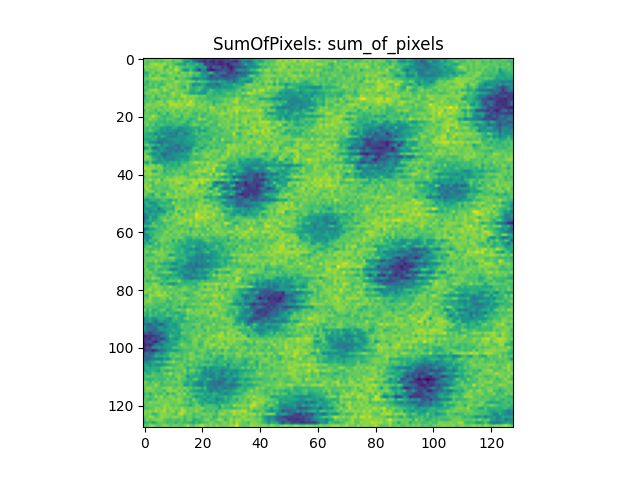

In [17]:
%autoreload
res_pixelsum = ctx.run_udf(dataset=ds, udf=udf, plots=True)

In [18]:
def my_custom_channel(udf_result):
    return udf_result['sum_of_pixels'].data > 9.1e4

def my_custom_channel_2(udf_result):
    return udf_result['sum_of_pixels'].data**2

In [19]:
%autoreload
live_plot = MPLLive2DPlot(dataset=ds, udf=udf, channel='sum_of_pixels')
live_plot_2 = MPLLive2DPlot(dataset=ds, udf=udf, channel=my_custom_channel)
live_plot_3 = MPLLive2DPlot(dataset=ds, udf=udf, channel=my_custom_channel_2, title="Hello")

In [ ]:
live_plot.display()
live_plot_2.display()
live_plot_3.display()

In [ ]:
%%time
ctx.run_udf(dataset=ds, udf=udf, plots=[live_plot, live_plot_2, live_plot_3])

In [ ]:
from libertem.udf.raw import PickUDF

In [ ]:
roi = np.zeros(ds.shape.nav, dtype=bool)
roi[0,0] = True
pick_udf = PickUDF()

In [ ]:
%autoreload
ctx.run_udf(dataset=ds, udf=pick_udf, roi=roi, plots=True)